# Система автоматизированного выбора и настройки алгоритма классификации задачи кредитного скоринга

## Загрузка и анализ данных

### Загрузка библиотек, датасета для кредитного скоринга

Библиотеки:
* pandas
* sklearn
* kagglehub
* matplotlib
* seaborn
* tpot
* h20

In [144]:
import warnings
warnings.filterwarnings("ignore")

In [145]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import utils
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import MinMaxScaler

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
#matplotlib inline

In [146]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kornilovag94/bank-credit-default-loan-default")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AntMur00\.cache\kagglehub\datasets\kornilovag94\bank-credit-default-loan-default\versions\2


In [147]:
data = pd.read_parquet(path+'/data/train_data/train_data_0.pq')

In [148]:
dataset_count=len(data)
print(f"Количество записей в первом файле датасета: {dataset_count}")

Количество записей в первом файле датасета: 1974724


In [149]:
import os
i = 1
while os.path.isfile(path+f'/data/train_data/train_data_{i}.pq'):
    temp_path = path+f'/data/train_data/train_data_{i}.pq'
    data_temp = len(pd.read_parquet(temp_path))
    dataset_count += data_temp
    i+=1
print(f"Общее количество записей в датасете: {dataset_count}")

Общее количество записей в датасете: 26162717


In [150]:
pd.set_option('display.max_columns', None)
data.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        3                      3                        0   
2                        0                      5                        0   
3                        2                      3                        0   
4                        2                      3                        0   

   pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  \
0                          2                          11           6   
1                          2                          11           6   
2                          2                           8           6   
3                          2                           4           6   
4                          2                           4           6   

   pre_loans530  pre_loans3060  pre_loans6090  pre_loans90  is_zero_loans5  \
0            16              5              4            8               1   
1            16              5              4            8               1   
2            16              5              4            8               1   
3            16              5              4            8               0   
4            16              5              4            8               1   

   is_zero_loans530  is_zero_loans3060  is_zero_loans6090  is_zero_loans90  \
0                 1                  1                  1                1   
1                 1                  1                  1                1   
2                 1                  1                  1                1   
3                 1                  1                  1                1   
4                 1                  1                  1                1   

   pre_util  pre_over2limit  pre_maxover2limit  is_zero_util  \
0        16               2                 17             1   
1        16               2                 17             1   
2        15               2                 17             0   
3        16               2                 17             1   
4        16               2                 17             1   

   is_zero_over2limit  is_zero_maxover2limit  enc_paym_0  enc_paym_1  \
0                   1                      1           0           0   
1                   1                      1           0           0   
2                   1                      1           0           0   
3                   1                      1           1           0   
4                   1                      1           0           0   

   enc_paym_2  enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  \
0           3           3           3           3           3           3   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           3   

   enc_paym_8  enc_paym_9  enc_paym_10  enc_paym_11  enc_p

In [151]:
pd.reset_option('display.max_columns')

### Признаки


* id - идентификатор заявки;
* rn - порядковый номер кредитного продукта в кредитной истории;
* pre_since_opened - дни с даты открытия кредита до даты сбора данных;
* pre_since_confirmed - дни с даты подтверждения кредитной информации до даты сбора данных;
* pre_pterm - планируемое количество дней с даты открытия кредита до даты закрытия;
* pre_fterm - фактическое количество дней. с даты открытия кредита до даты закрытия;
* pre_till_pclose - планируемое количество дней с даты сбора данных до даты закрытия кредита;
* pre_till_fclose - фактическое количество дней с даты сбора данных до даты закрытия кредита;
* pre_loans_credit_limit - кредитный лимит;
* pre_loans_next_pay_summ - сумма следующего платежа по кредиту;
* pre_loans_outstanding - сумма непогашенного кредита;
* pre_loans_total_overdue - текущая сумма просрочки;
* pre_loans_max_overdue_sum - максимальная сумма просрочки;
* pre_loans_credit_cost_rate - общая стоимость кредита;
* pre_loans5 - количество просрочка до 5 дней;
* pre_loans530 - номер количество просрочек от 5 до 30 дней;
* pre_loans3060 - количество просрочек от 30 до 60 дней;
* pre_loans6090 - количество просрочек от 60 до 90 дней;
* pre_loans90 - количество просрочек более 90 дней;
* is_zero_loans_5 - флаг: нет просрочек до 5 дней;
* is_zero_loans_530 - флаг: нет просрочек от 5 до 30 дней;
* is_zero_loans_3060 - флаг: нет просрочек от 30 до 60 дней;
* is_zero_loans_6090 - флаг: нет правонарушения в области от 60 до 90 дней;
* is_zero_loans90 - флаг: просрочки не превышают 90 дней;
* pre_util - отношение суммы непогашенного кредита к кредитному лимиту;
* pre_over2limit - отношение текущей просроченной задолженности к кредитному лимиту;
* pre_maxover2limit - отношение максимальной просроченной задолженности к кредитному лимиту;
* is_zero_util - флаг: отношение суммы непогашенного кредита к кредитному лимиту равно 0;
* is_zero_over2limit - флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0;
* is_zero_maxover2limit - флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0;
* enc_paym_{0...n} - ежемесячно статусы платежей за последние n месяцев;
* enc_loans_account_holder_type - тип отношения к кредиту;
* enc_loans_credit_status - статус кредита;
* enc_loans_account_cur - валюта кредита;
* enc_loans_credit_type - тип кредита; 
* pclose_flag - флаг: планируемое количество дней с даты открытия до даты закрытия кредита;
* fclose_flag - флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

In [152]:
data.shape

(1974724, 61)

## Предобработка данных

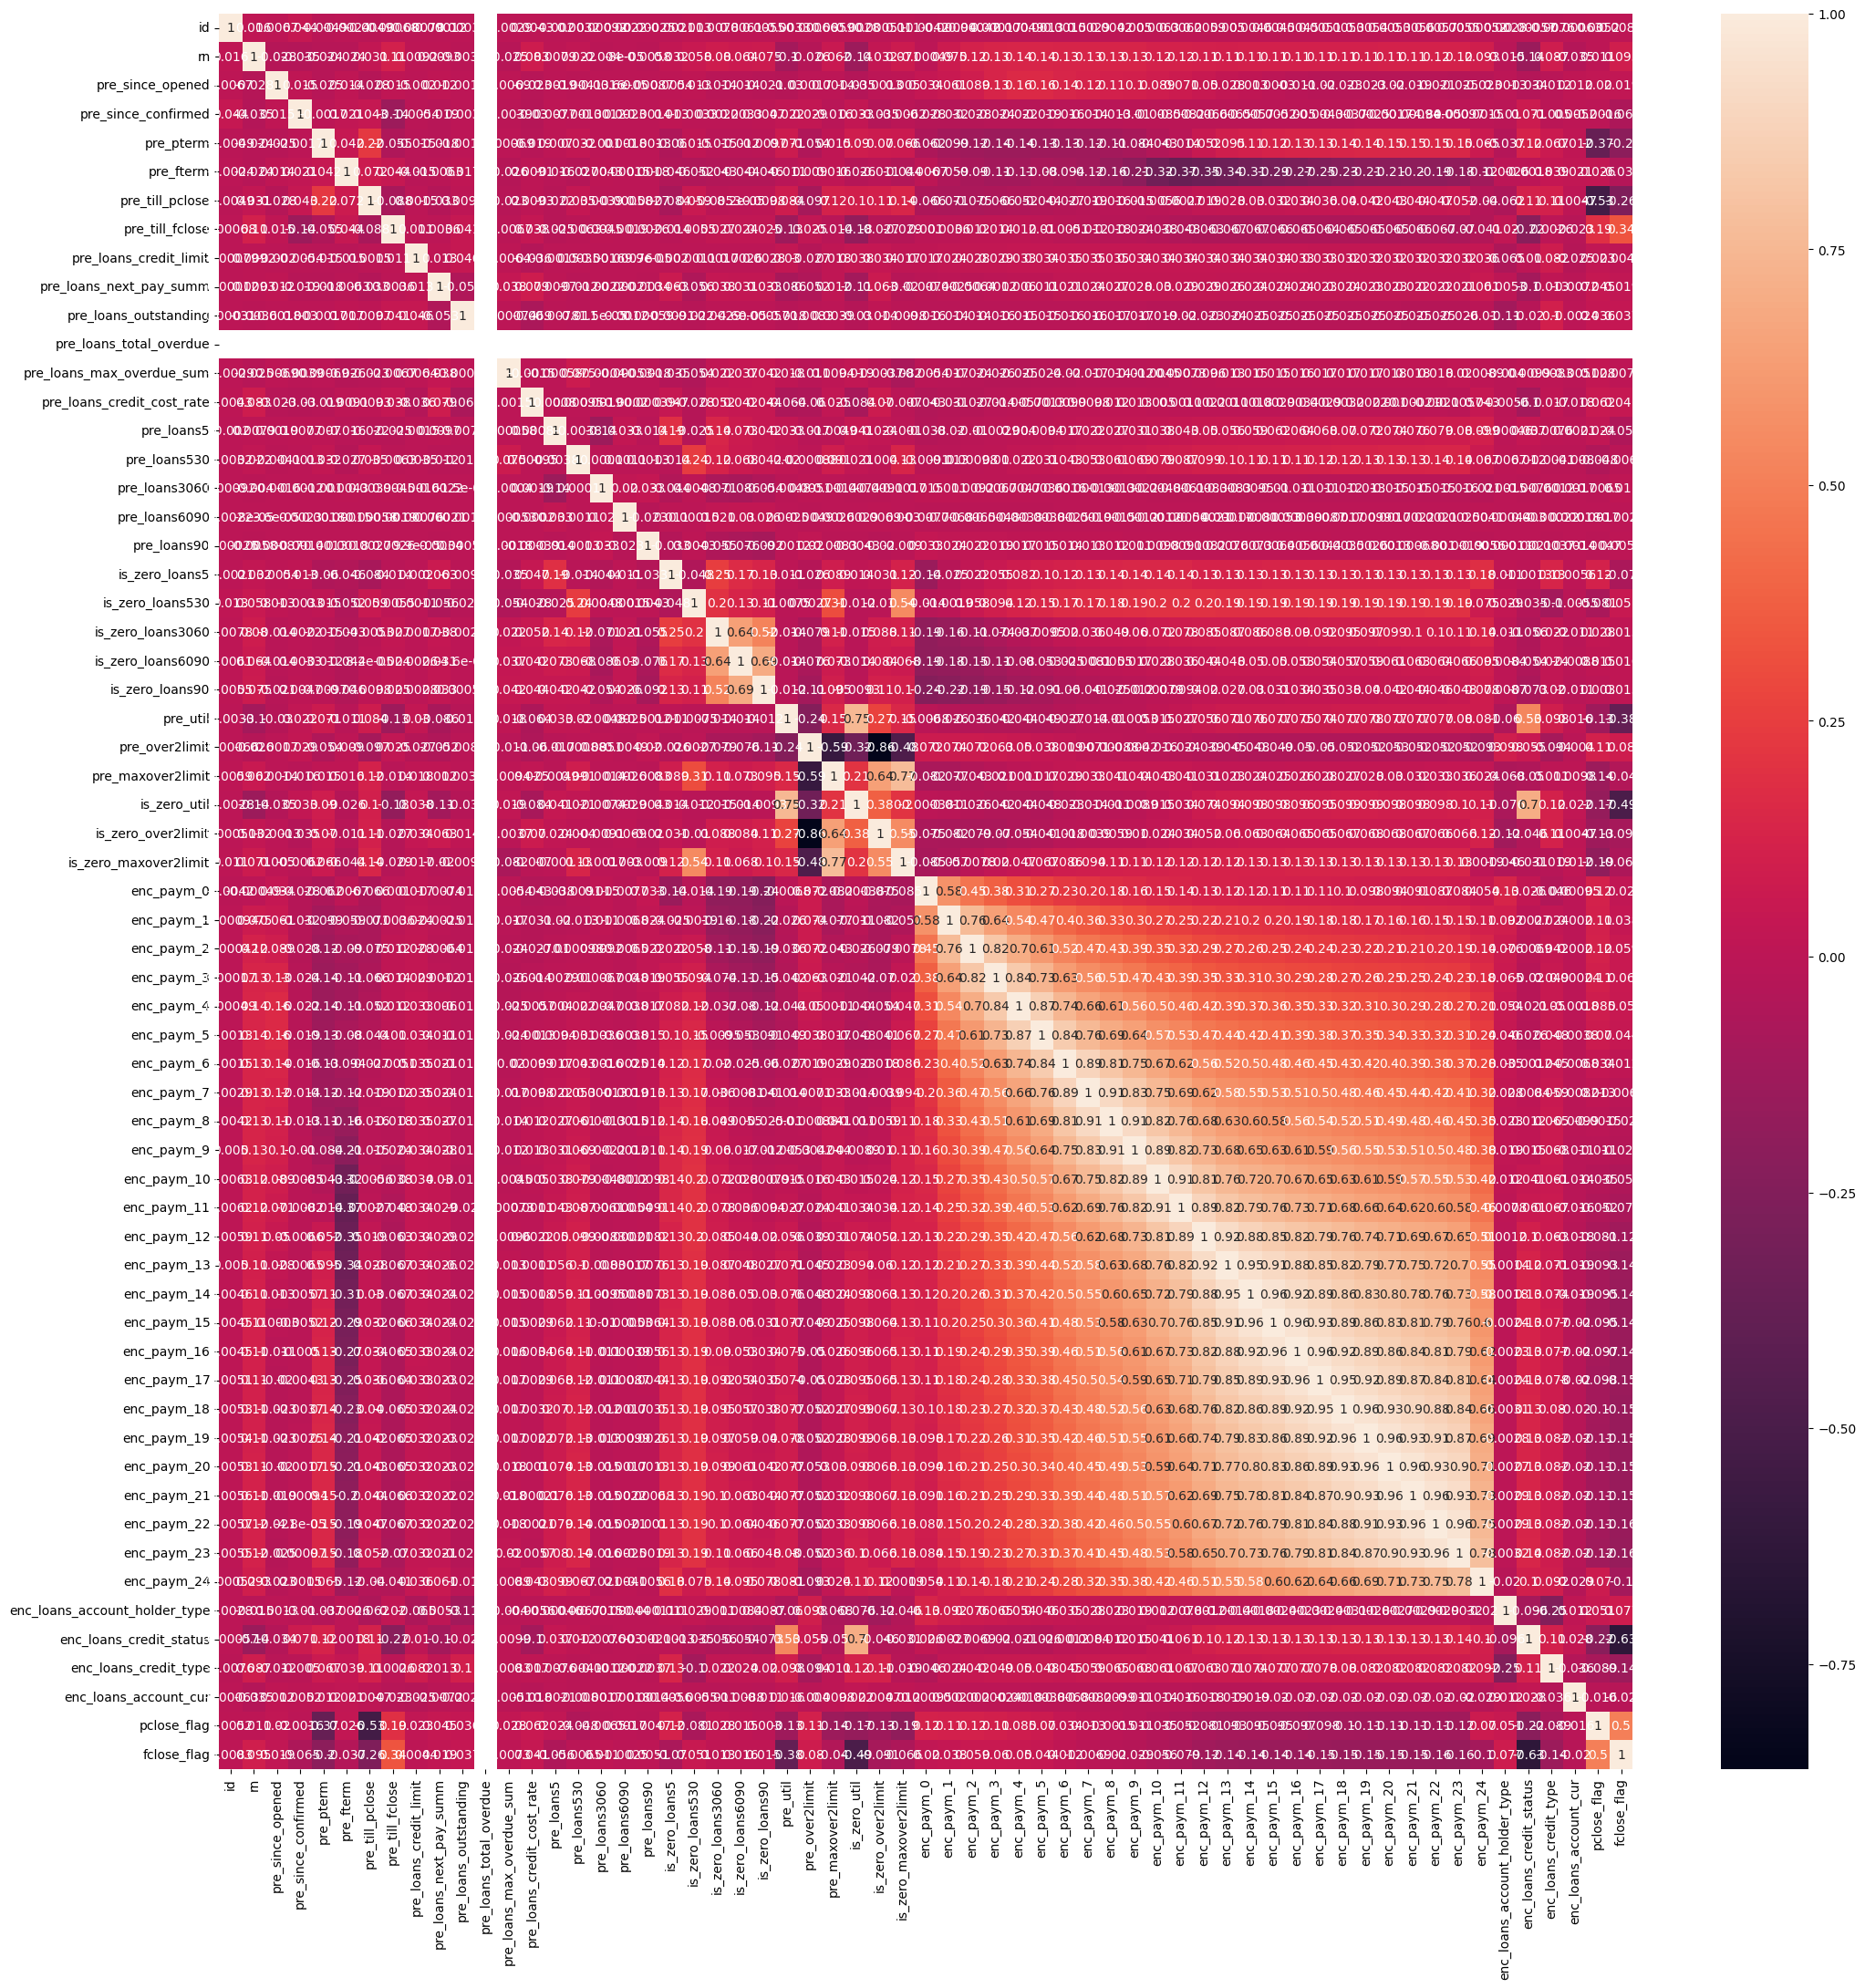

In [153]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data.corr(), annot=True);

In [154]:
data.drop(columns=['rn','pre_loans_total_overdue','pre_loans_max_overdue_sum',
       'pre_loans_outstanding', 'pre_till_pclose',
       'pre_till_fclose', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
       'pre_loans6090', 'pre_loans90', 'pclose_flag', 'fclose_flag',
       'enc_loans_account_cur'], inplace=True)

In [155]:
data.dtypes

id                               int64
pre_since_opened                 int64
pre_since_confirmed              int64
pre_pterm                        int64
pre_fterm                        int64
pre_loans_credit_limit           int64
pre_loans_next_pay_summ          int64
pre_loans_credit_cost_rate       int64
is_zero_loans5                   int64
is_zero_loans530                 int64
is_zero_loans3060                int64
is_zero_loans6090                int64
is_zero_loans90                  int64
pre_util                         int64
pre_over2limit                   int64
pre_maxover2limit                int64
enc_paym_0                       int64
enc_paym_1                       int64
enc_paym_2                       int64
enc_paym_3                       int64
enc_paym_4                       int64
enc_paym_5                       int64
enc_paym_6                       int64
enc_paym_7                       int64
enc_paym_8                       int64
enc_paym_9               

In [156]:
data_2 = pd.read_csv(path+'/target.csv')

In [157]:
data_2 = data_2.iloc[:250000]
data_2.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [158]:
data_2.shape

(250000, 2)

In [159]:
merged_data = pd.merge(data, data_2 , on = 'id')
merged_data.shape

(1974724, 45)

In [160]:
merged_data.drop(columns=['id'], inplace=True)

In [161]:
merged_data.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_loans_credit_limit  pre_loans_next_pay_summ  \
0                      11                        3   
1                       0                        3   
2                      11                        0   
3                      12                        2   
4                      10                        2   

   pre_loans_credit_cost_rate  is_zero_loans5  is_zero_loans530  \
0                          11               1                 1   
1                          11               1                 1   
2                           8               1                 1   
3                           4               0                 1   
4                           4               1                 1   

   is_zero_loans3060  ...  enc_paym_19  enc_paym_20  enc_paym_21  enc_paym_22  \
0                  1  ...            3            4            3            3   
1                  1  ...            0            1            0            0   
2                  1  ...            0            1            0            0   
3                  1  ...            3            4            3            3   
4                  1  ...            3            4            3            3   

   enc_paym_23  enc_paym_24  enc_loans_account_holder_type  \
0            3            4                              1   
1            0            4                              1   
2            0            4                              1   
3            3            4                              1   
4            3            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  flag  
0                        3                      4     0  
1                        3                      4     0  
2                        2                      3     0  
3                        3                      1     0  
4                        3                      4     0  

[5 rows x 44 columns]

In [162]:
merged_data['flag'] = merged_data['pre_since_opened'].apply(lambda x: 1 if x > 10 else 0)

In [163]:
merged_data.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_credit_cost_rate       0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
enc_paym_0                       0
enc_paym_1                       0
enc_paym_2                       0
enc_paym_3                       0
enc_paym_4                       0
enc_paym_5                       0
enc_paym_6                       0
enc_paym_7                       0
enc_paym_8                       0
enc_paym_9                       0
enc_paym_10                      0
enc_paym_11                      0
enc_paym_12                      0
enc_paym_13         

In [164]:
flag_counts = merged_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = merged_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    1154627
1     820097
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.584703
1    0.415297
Name: proportion, dtype: float64


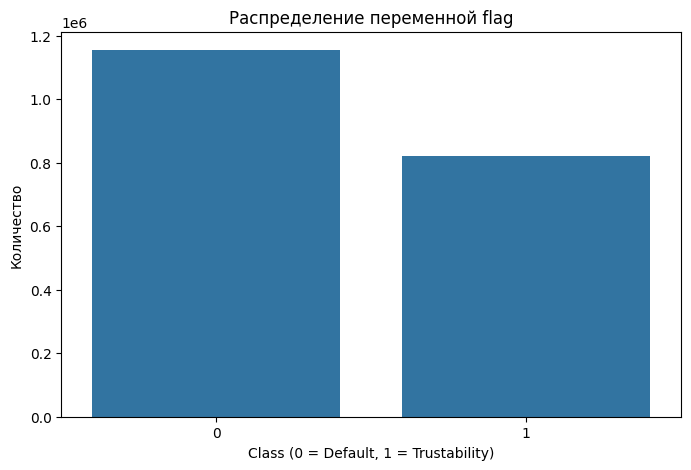

In [165]:
plt.figure(figsize=(8, 5))
sns.countplot(x="flag", data=merged_data)
plt.title("Распределение переменной flag")
plt.xlabel("Class (0 = Default, 1 = Trustability)")
plt.ylabel("Количество")
plt.show()

In [166]:
def corr_matrix(corr):
    plt.figure(figsize=(25,25))

    sns.heatmap(corr, annot=True)

    plt.title('Корреляция признаков')
    plt.show()

    corr_df = pd.DataFrame(corr)
    correlation_matrix = corr_df.corr()

    correlation_threshold = 0.9
    highly_correlated_columns = []

    for column in correlation_matrix:
        correlated_columns = correlation_matrix[column][correlation_matrix[column] > correlation_threshold].index.tolist()
        highly_correlated_columns.extend([(column, correlated_column, correlation_matrix[column][correlated_column]) for correlated_column in correlated_columns])
    # Print the highly correlated column pairs
    for pair in highly_correlated_columns:
        if not pair[0]==pair[1]:
            print(f"Columns '{pair[0]}' and '{pair[1]}' are highly correlated: {pair[2]:.3f}")

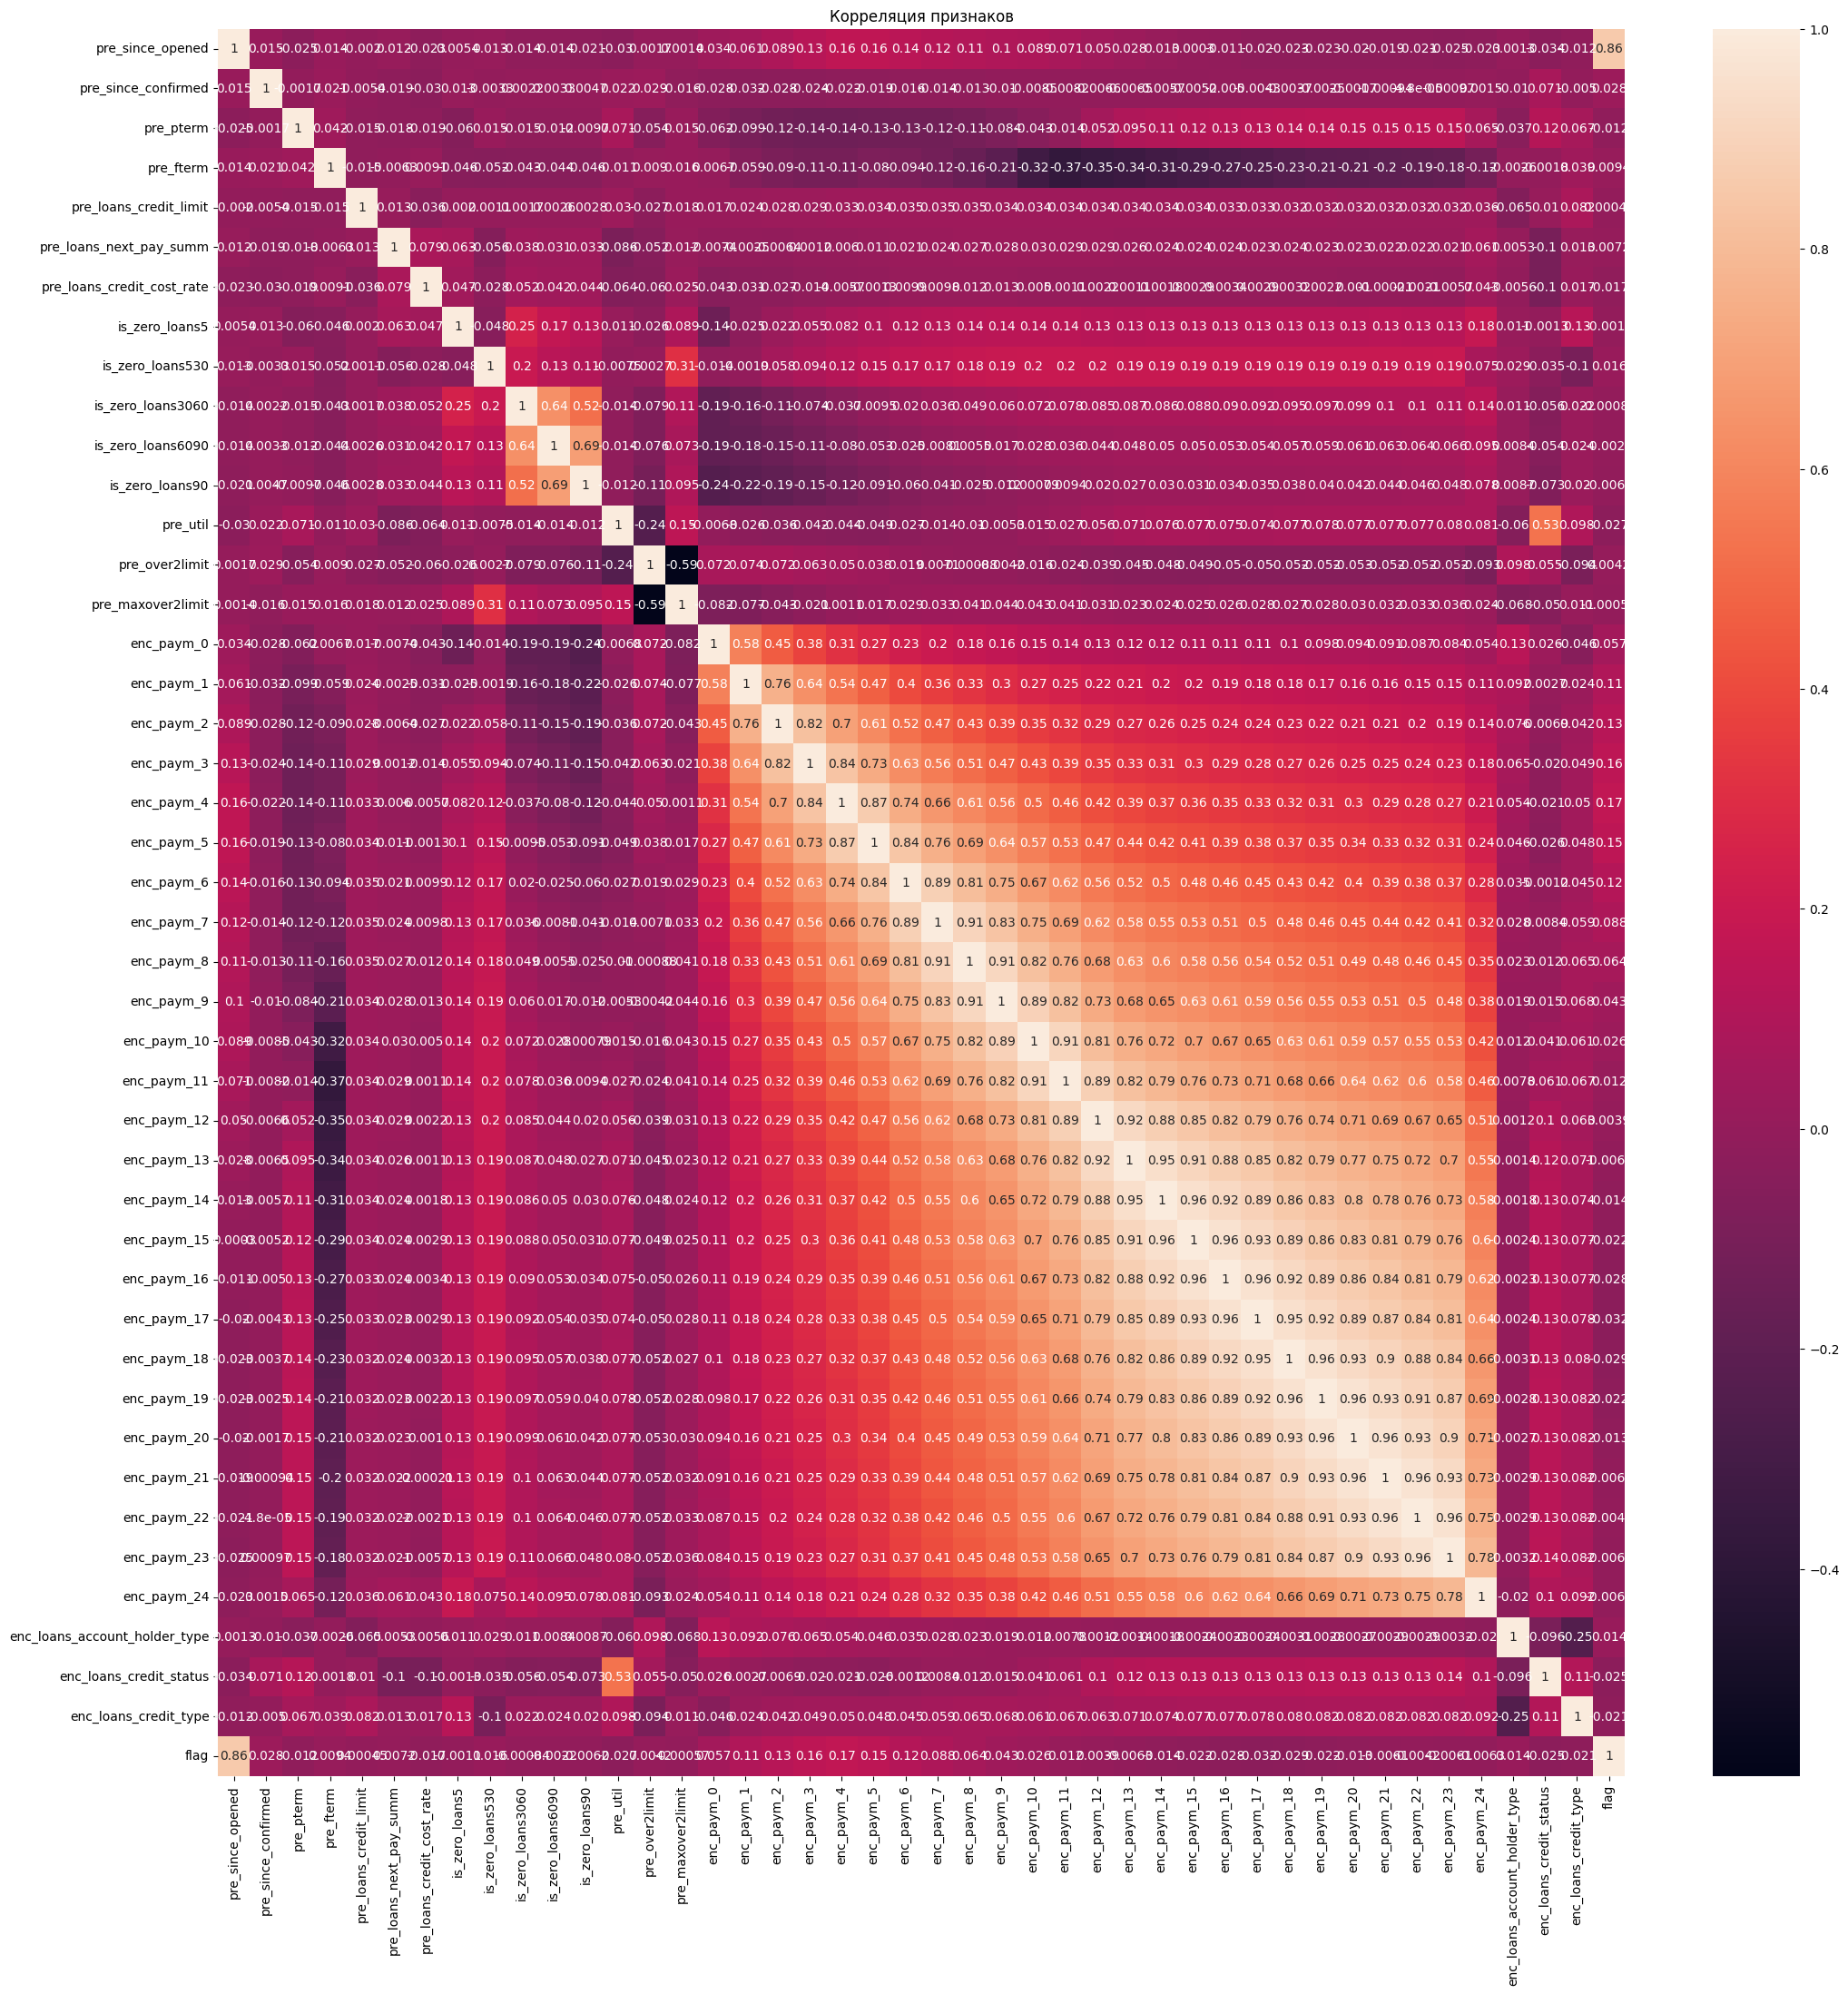

Columns 'pre_since_opened' and 'flag' are highly correlated: 0.981
Columns 'is_zero_loans3060' and 'is_zero_loans6090' are highly correlated: 0.915
Columns 'is_zero_loans6090' and 'is_zero_loans3060' are highly correlated: 0.915
Columns 'is_zero_loans6090' and 'is_zero_loans90' are highly correlated: 0.945
Columns 'is_zero_loans90' and 'is_zero_loans6090' are highly correlated: 0.945
Columns 'enc_paym_1' and 'enc_paym_2' are highly correlated: 0.962
Columns 'enc_paym_1' and 'enc_paym_3' are highly correlated: 0.907
Columns 'enc_paym_2' and 'enc_paym_1' are highly correlated: 0.962
Columns 'enc_paym_2' and 'enc_paym_3' are highly correlated: 0.977
Columns 'enc_paym_2' and 'enc_paym_4' are highly correlated: 0.929
Columns 'enc_paym_3' and 'enc_paym_1' are highly correlated: 0.907
Columns 'enc_paym_3' and 'enc_paym_2' are highly correlated: 0.977
Columns 'enc_paym_3' and 'enc_paym_4' are highly correlated: 0.979
Columns 'enc_paym_3' and 'enc_paym_5' are highly correlated: 0.940
Columns 'e

In [167]:
corr_matrix(merged_data.corr())

In [168]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

In [169]:
data_filtered = drop_highly_correlated(merged_data)

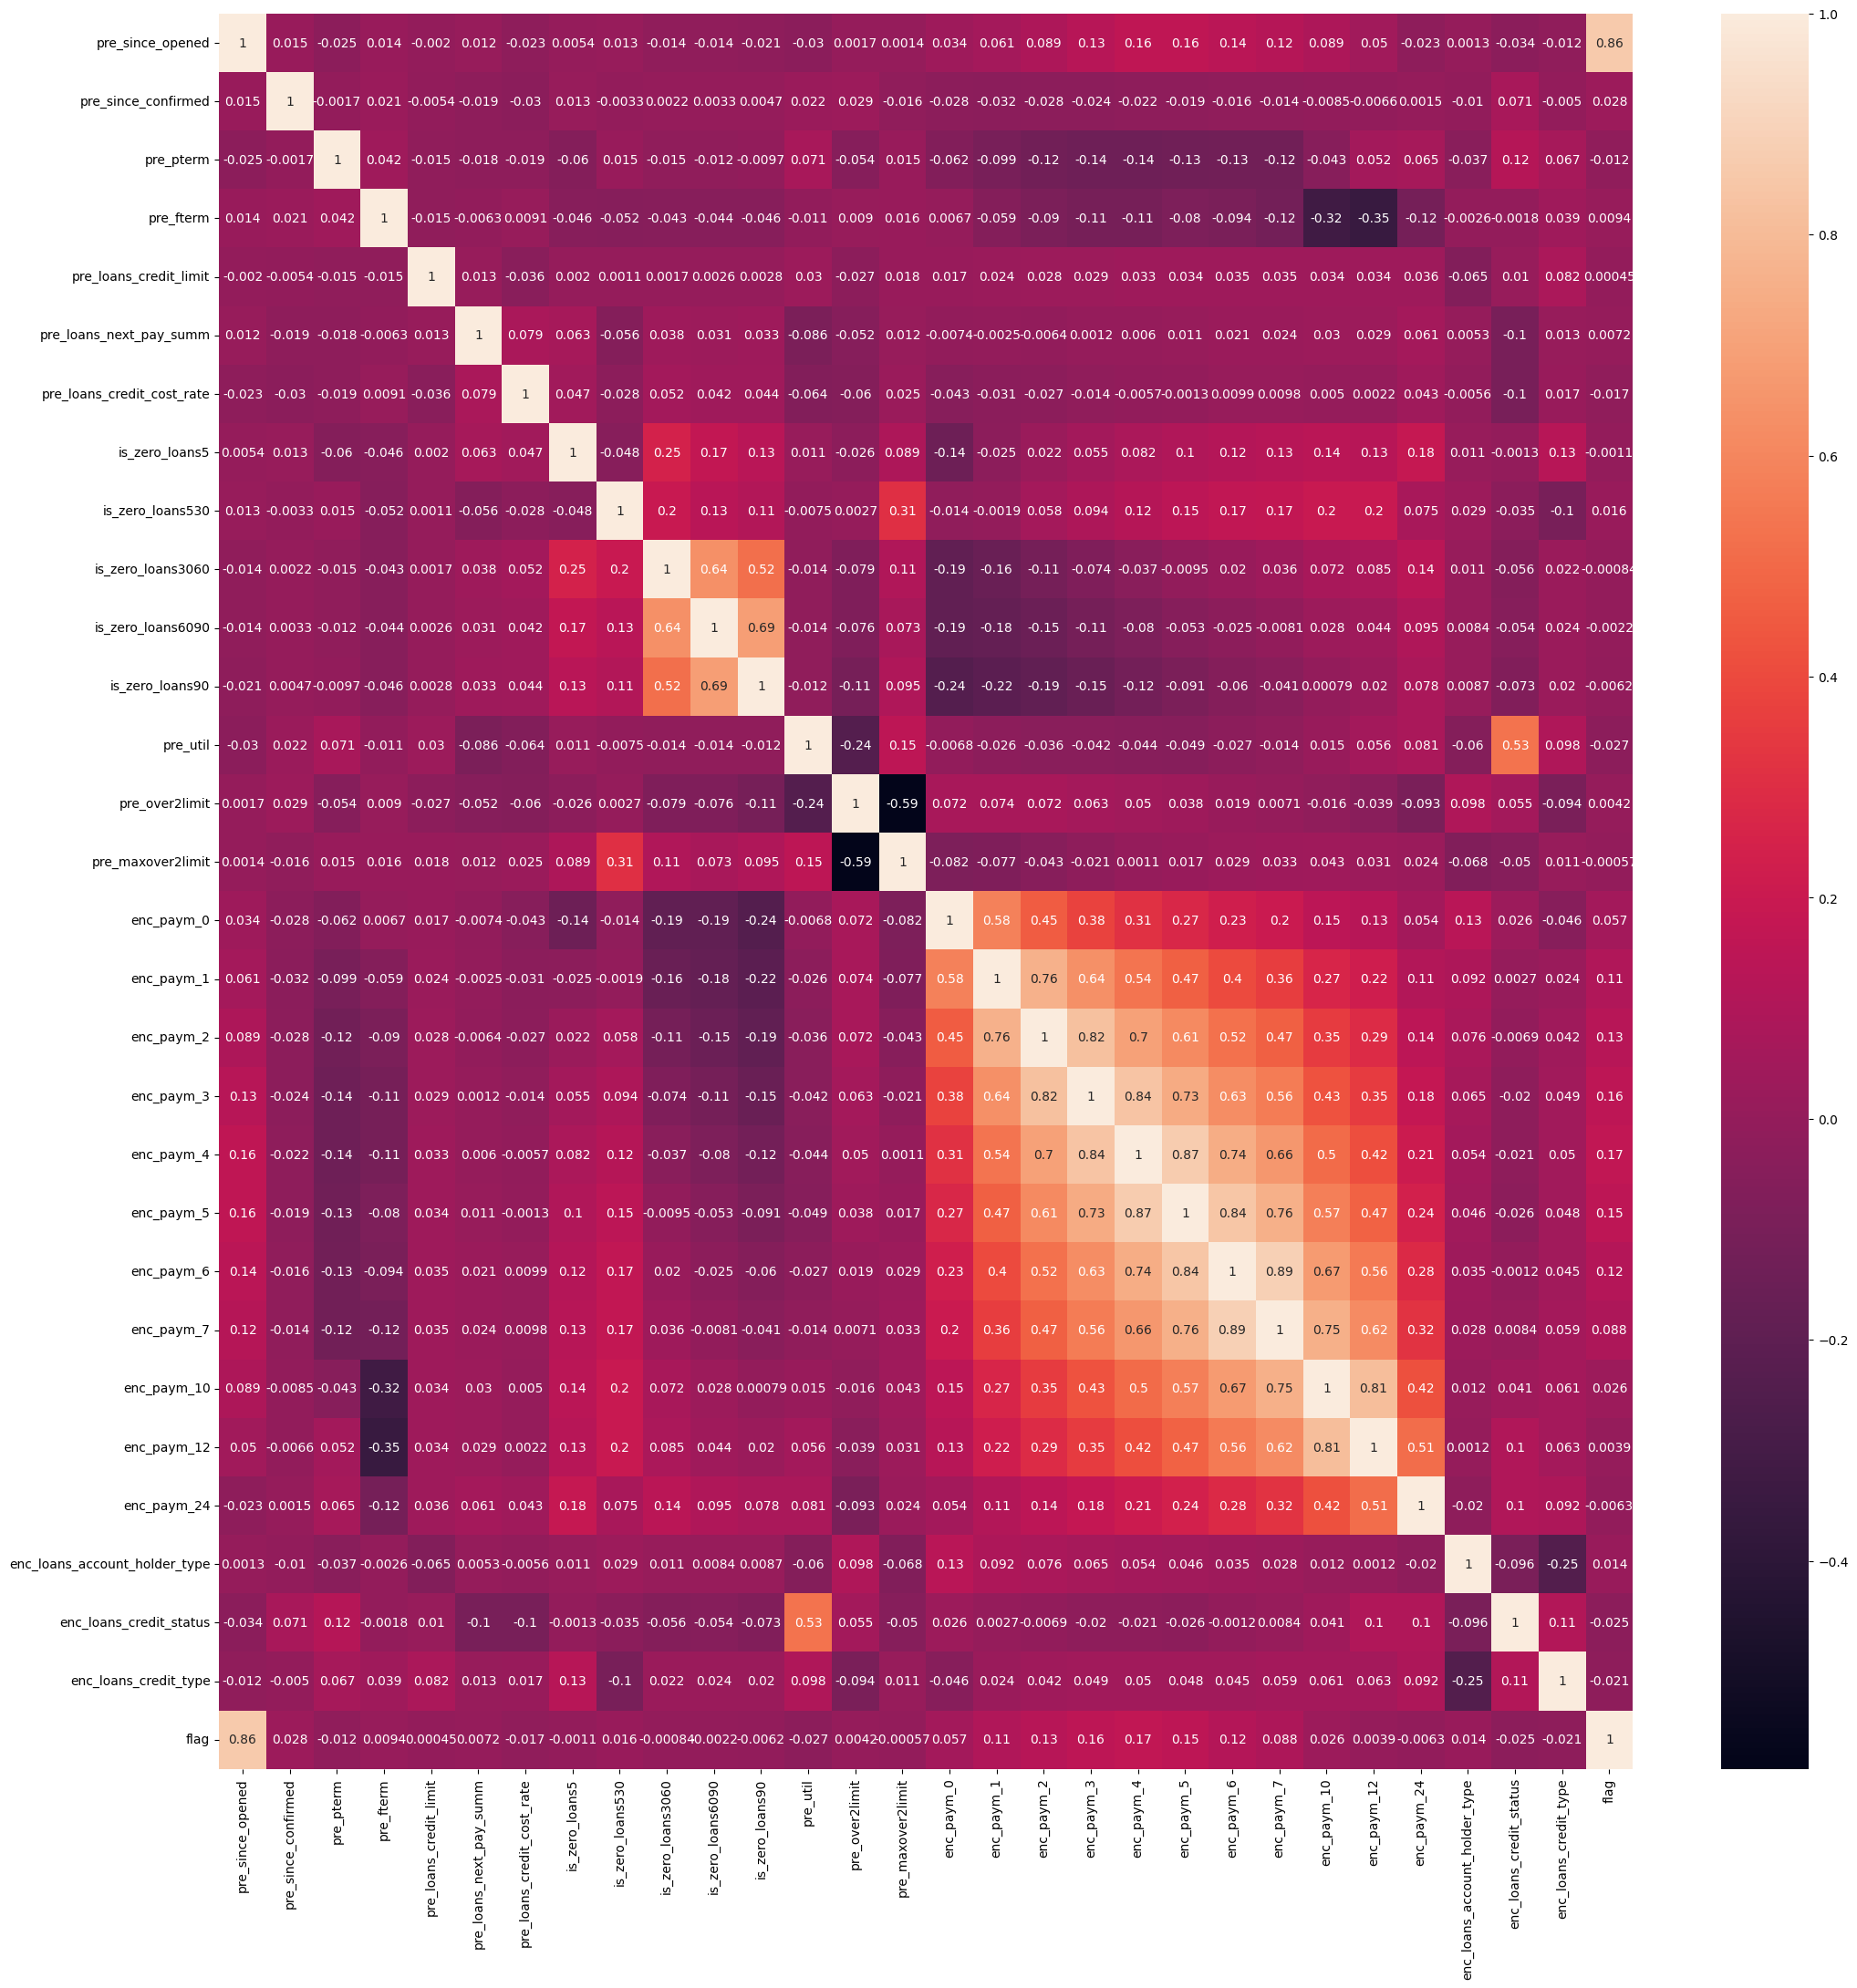

In [170]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data_filtered.corr(), annot=True);

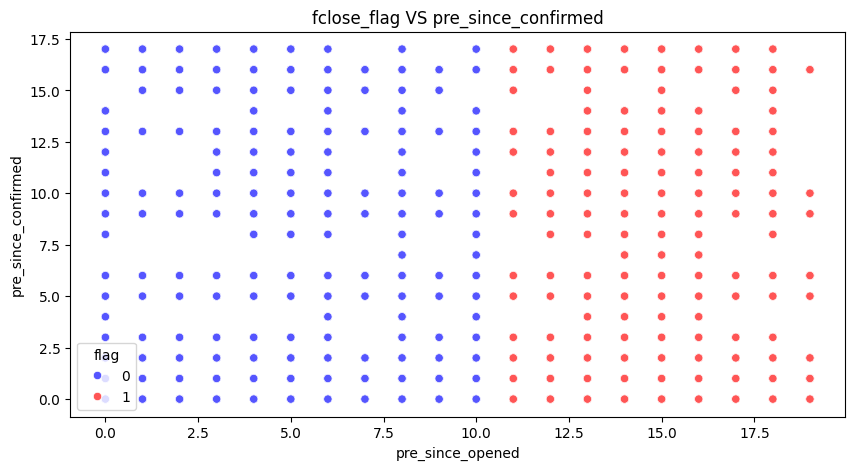

In [171]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=data_filtered, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue='flag', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [172]:
pd.set_option('display.max_columns', None)
data_filtered.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_loans_credit_limit  pre_loans_next_pay_summ  \
0                      11                        3   
1                       0                        3   
2                      11                        0   
3                      12                        2   
4                      10                        2   

   pre_loans_credit_cost_rate  is_zero_loans5  is_zero_loans530  \
0                          11               1                 1   
1                          11               1                 1   
2                           8               1                 1   
3                           4               0                 1   
4                           4               1                 1   

   is_zero_loans3060  is_zero_loans6090  is_zero_loans90  pre_util  \
0                  1                  1                1        16   
1                  1                  1                1        16   
2                  1                  1                1        15   
3                  1                  1                1        16   
4                  1                  1                1        16   

   pre_over2limit  pre_maxover2limit  enc_paym_0  enc_paym_1  enc_paym_2  \
0               2                 17           0           0           3   
1               2                 17           0           0           0   
2               2                 17           0           0           0   
3               2                 17           1           0           0   
4               2                 17           0           0           0   

   enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  enc_paym_10  \
0           3           3           3           3           3            3   
1           0           0           0           0           0            0   
2           0           0           0           0           0            0   
3           0           0           0           0           0            0   
4           0           0           0           0           3            3   

   enc_paym_12  enc_paym_24  enc_loans_account_holder_type  \
0            3            4                              1   
1            0            4                              1   
2            0            4                              1   
3            3            4                              1   
4            3            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  flag  
0                        3                      4     1  
1                        3                      4     1  
2                        2                      3     1  
3                        3                      1     0  
4                        3                      4     0

In [173]:
pd.reset_option('display.max_columns')

Применение One-Hot-Encoder (Pandas)

In [174]:
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_account_holder_type'], prefix='enc_loans_account_holder_type', drop_first=True)
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_credit_status'], prefix='enc_loans_credit_status', drop_first=True)
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_credit_type'], prefix='enc_loans_credit_type', drop_first=True)
for i in range(25):
    if f'enc_paym_{i}' in data_filtered.columns:
        data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=[f'enc_paym_{i}'], prefix=f'enc_paym_{i}', drop_first=True)

In [175]:
data_filtered.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_loans_credit_limit  pre_loans_next_pay_summ  \
0                      11                        3   
1                       0                        3   
2                      11                        0   
3                      12                        2   
4                      10                        2   

   pre_loans_credit_cost_rate  is_zero_loans5  is_zero_loans530  \
0                          11               1                 1   
1                          11               1                 1   
2                           8               1                 1   
3                           4               0                 1   
4                           4               1                 1   

   is_zero_loans3060  ...  enc_paym_7_3  enc_paym_10_1  enc_paym_10_2  \
0                  1  ...             1              0              0   
1                  1  ...             0              0              0   
2                  1  ...             0              0              0   
3                  1  ...             0              0              0   
4                  1  ...             1              0              0   

   enc_paym_10_3  enc_paym_12_1  enc_paym_12_2  enc_paym_12_3  enc_paym_24_2  \
0              1              0              0              1              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              1              0   
4              1              0              0              1              0   

   enc_paym_24_3  enc_paym_24_4  
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  

[5 rows x 66 columns]

In [176]:
#уменьшение выборки для демонстрации работы TPOT и H2O
test_data = data_filtered[1000000:1000500]
train_data = data_filtered[:1000]

In [177]:
flag_counts = test_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = test_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    296
1    204
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.592
1    0.408
Name: proportion, dtype: float64


In [178]:
flag_counts = train_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = train_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    578
1    422
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.578
1    0.422
Name: proportion, dtype: float64


In [179]:
def x_y_split(df):
    X = df.drop(columns=['flag'])
    y = df['flag']
    return X, y

In [180]:
X, y = x_y_split(train_data)

In [181]:
X_test, y_test = x_y_split(test_data)

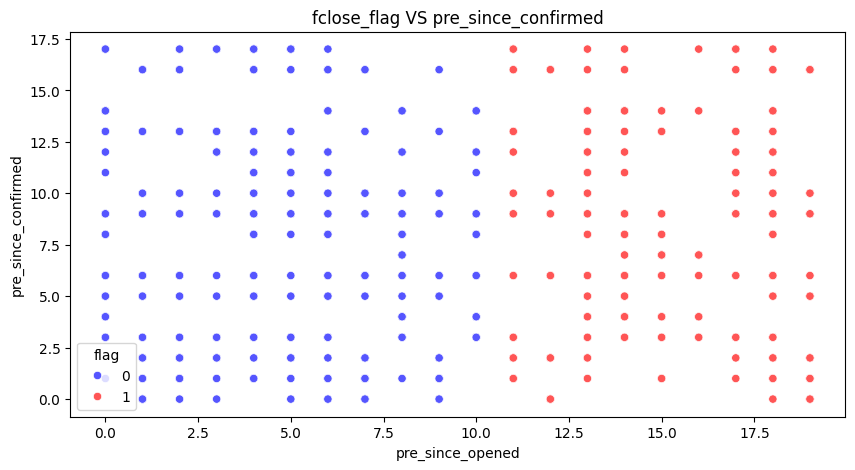

In [182]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=train_data, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue=y, #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение TPOT

### Функции метрик

In [184]:
def tpot_prediction(test_data, model):
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    return y_pred, y_proba

In [185]:
def metrics(y_test, y_pred, y_proba):
    # Вычисление метрик
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print()
    # Матрица ошибок
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # Полный отчет
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Процесс обучения

In [186]:
#%pip install tpot

In [187]:
from sklearn import utils
import tpot
from tpot import TPOTClassifier

In [188]:
tpot_generations = [5, 10]
tpot_popsize = [50, 100]
tpot_models = []

In [ ]:
# проводим обучение нескольких моделей tpot
for gen_param in tpot_generations:
    for pop_param in tpot_popsize:
        tpot = TPOTClassifier(
            generations=gen_param,
            population_size=pop_param,
            random_state=42,
            cv=5,
            #n_jobs=-1,
            scorers='recall',
        )
        tpot.fit(X_train, y_train)
        tpot_models.append(tpot)

In [ ]:
for tpot in tpot_models:
    print(f'{tpot_models.index(tpot)+1} tpot model: generations={tpot.generations}, pop_size={tpot.population_size}')
    y_pred, y_proba = tpot_prediction(X_val, tpot)
    metrics(y_val, y_pred, y_proba)

    print('\nBest pipeline steps:', end='\n')
    for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
        print(f'{idx}. {transform}')
    
    test_predictions, test_probablity = tpot_prediction(X_test, tpot)
    metrics(y_test, test_predictions, test_probablity)
    
    if not (tpot_models.index(tpot) == len(tpot_models)-1):
        print('\n'+('-='*20)+'-\n')

    tpot.export(f'/tpot_models/tpot_pipeline_{tpot_models.index(tpot)+1}.py')

1 tpot model: generations=5, pop_size=50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC_AUC: 1.0000

Confusion Matrix:
 [[178   0]
 [  0 122]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       122

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Best pipeline steps:
1. MinMaxScaler()
2. RFE(estimator=ExtraTreesClassifier(max_features=0.4503212524738,
                                   min_samples_leaf=4, min_samples_split=7,
                                   n_jobs=1, random_state=42),
    step=0.9162776237062)
3. FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('binarizer',
                                                                Binarizer(thresh

In [ ]:
# Экспорт лучшего пайплайна в виде Python-кода
# tpot.export('tpot_pipeline.py')

## Обучение H2O

In [ ]:
#%pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# Ячейка 2: Инициализация H2O и загрузка данных
h2o.init(nthreads=-1, max_mem_size="4G", ip="127.0.0.1", port='54321')

Checking whether there is an H2O instance running at http://127.0.0.1:54321. connected.


--------------------------  -------------------------------
H2O_cluster_uptime:         3 hours 29 mins
H2O_cluster_timezone:       Asia/Yekaterinburg
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    30 days
H2O_cluster_name:           H2O_from_python_AntMur00_zs3l3l
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.046 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.10 final
--------------------------  -------------------------------

In [ ]:
X_train, y_train = x_y_split(train_data)
X_test, y_test = x_y_split(test_data)

In [ ]:
h2o_train_X, h2o_val_X, h2o_train_y, h2o_val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
print(f'h2o_train_X.shape :{h2o_train_X.shape}')
print(f'h2o_val_X.shape:{h2o_val_X.shape}')
print(f'X_test.shape:{X_test.shape}')

h2o_train_X.shape :(700, 65)
h2o_val_X.shape:(300, 65)
X_test.shape:(500, 65)


In [ ]:
h2o_train_y = h2o_train_y.apply(lambda x: "yes" if x == 1 else "no")
h2o_val_y = h2o_val_y.apply(lambda x: "yes" if x == 1 else "no")
y_test = y_test.apply(lambda x: "yes" if x == 1 else "no")

In [ ]:
# Преобразование в H2O фреймы
train_h2o = h2o.H2OFrame(pd.concat([h2o_train_X, h2o_train_y], axis=1))
val_h2o = h2o.H2OFrame(pd.concat([h2o_val_X, h2o_val_y], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Определение целевой переменной и признаков
target = 'flag'
features = list(train_data.columns)

In [ ]:
train_h2o

pre_since_opened    pre_since_confirmed    pre_pterm    pre_fterm    pre_loans_credit_limit    pre_loans_next_pay_summ    pre_loans_credit_cost_rate    is_zero_loans5    is_zero_loans530    is_zero_loans3060    is_zero_loans6090    is_zero_loans90    pre_util    pre_over2limit    pre_maxover2limit    enc_loans_account_holder_type_1    enc_loans_account_holder_type_2    enc_loans_account_holder_type_3    enc_loans_account_holder_type_4    enc_loans_account_holder_type_5    enc_loans_account_holder_type_6    enc_loans_credit_status_1    enc_loans_credit_status_2    enc_loans_credit_status_3    enc_loans_credit_status_4    enc_loans_credit_status_5    enc_loans_credit_status_6    enc_loans_credit_type_1    enc_loans_credit_type_2    enc_loans_credit_type_3    enc_loans_credit_type_4    enc_loans_credit_type_5    enc_paym_0_1    enc_paym_0_2    enc_paym_0_3    enc_paym_1_1    enc_paym_1_2    enc_paym_1_3    enc_paym_2_1    enc_paym_2_2    enc_paym_2_3    enc_paym_3_1    enc_paym_3_2    enc_paym_3_3    enc_paym_4_1    enc_paym_4_2    enc_paym_4_3    enc_paym_5_1    enc_paym_5_2    enc_paym_5_3    enc_paym_6_1    enc_paym_6_2    enc_paym_6_3    enc_paym_7_1    enc_paym_7_2    enc_paym_7_3    enc_paym_10_1    enc_paym_10_2    enc_paym_10_3    enc_paym_12_1    enc_paym_12_2    enc_paym_12_3    enc_paym_24_2    enc_paym_24_3    enc_paym_24_4  flag
------------------  ---------------------  -----------  -----------  ------------------------  -------------------------  ----------------------------  ----------------  ------------------  -------------------  -------------------  -----------------  ----------  ----------------  -------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  -------------------------  -------------------------  -------------------------  -------------------------  -------------------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ------
                18                     11           12           15                         1                          2                             2                 1                   1                    1                    1                  1          16                 2                   17                                  1                                  0                                  0                                  0                                  0                                  0                            0                            0                            1                            0                            0                            0                          0                          0                          0                          1                          0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0                0                0                0                0   

In [ ]:
# Запуск H2O AutoML
aml = H2OAutoML(max_runtime_secs=3600, seed=42, verbosity='info', nfolds=5)
aml.train(x=features, y=target, training_frame=train_h2o, validation_frame=val_h2o)

AutoML progress: |
19:10:39.366: Project: AutoML_3_20250426_191039
19:10:39.366: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:10:39.366: Setting stopping tolerance adaptively based on the training frame: 0.03779644730092272
19:10:39.366: Build control seed: 42
19:10:39.367: training frame: Frame key: AutoML_3_20250426_191039_training_Key_Frame__upload_b17cf820fed64352256581fc564e415a.hex    cols: 66    rows: 700  chunks: 1    size: 15342  checksum: -2544033676518999824
19:10:39.367: validation frame: Frame key: Key_Frame__upload_95822c6202ebb21110bc4fa54b844e44.hex    cols: 66    rows: 300  chunks: 1    size: 9652  checksum: -2544023917385956112
19:10:39.367: leaderboard frame: NULL
19:10:39.367: blending frame: NULL
19:10:39.367: response column: flag
19:10:39.367: fold co

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20250426_191039_model_47


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    974                974                         213330                 1            4            3.87577       2             16            12.732

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0
RMSE: 0.0
LogLoss: 0.0
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0
       no    yes    Error    Rate
-----  ----  -----  -------  -----------
no     400   0      0        (0.0/400.0)
yes    0     300    0        (0.0/300.0)
Total  400   300    0        (0.0/700.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       1            1        0
max f2                       1            1        0
max f0point5                 1            1        0
max accuracy                 1            1        0
max precision                1            1        0
max recall                   1            1        0
max specificity              1            1        0
max absolute_mcc             1            1        0
max min_per_class_accuracy   1            1        0
max mean_per_class_accuracy  1            1        0
max tns                      1            400      0
max fns                      1            0        0
max fps                      1e-19        400      387
max tps                      1            300      0
max tnr                      1            1        0
max fnr                      1            0        0
max fpr                      1e-19        1        387
max tpr                      1            1        0

Gains/Lift Table: Avg response rate: 42,86 %, avg score: 42,86 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.428571                    1                  2.33333  2.33333            1                1            1                           1                   1               1                          133.333  133.333            1
2        0.5                         4.17744e-18        0        2                  0                6.56712e-18  0.857143                    0.857143            0               1                          -100     100                0.875
3        0.6                         2.28102e-18        0        1.66667            0                3.00344e-18  0.714286                    0.714286            0               1                          -100     66.6667            0.7
4        0.7                         1.38154e-18        0        1.42857            0                1.7982e-18   0.612245                    0.612245            0               1                          -100     42.8571            0.525
5        0.8                         7.87715e-19        0        1.25               0                1.05821e-18  0.535714                    0.535714            0               1                          -100     25                 0.35
6        0.9                         3.77198e-19        0        1.11111            0

In [ ]:
# Вывод Leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)


Leaderboard:
model_id                                                   auc      logloss    aucpr    mean_per_class_error         rmse          mse
GBM_grid_1_AutoML_3_20250426_191039_model_47                 1  7.9603e-16         1                       0  7.55634e-15  5.70982e-29
GBM_grid_1_AutoML_3_20250426_191039_model_9                  1  3.21806e-16        1                       0  2.86673e-15  8.21812e-30
StackedEnsemble_BestOfFamily_5_AutoML_3_20250426_191039      1  8.78689e-05        1                       0  9.4727e-05   8.97321e-09
GBM_grid_1_AutoML_3_20250426_191039_model_63                 1  6.69623e-16        1                       0  3.32493e-15  1.10552e-29
StackedEnsemble_BestOfFamily_2_AutoML_3_20250426_191039      1  9.01098e-05        1                       0  9.10702e-05  8.29378e-09
GBM_grid_1_AutoML_3_20250426_191039_model_62                 1  1.06299e-10        1                       0  1.39191e-09  1.9374e-18
GBM_grid_1_AutoML_3_20250426_191039_model_

In [ ]:
# Получение лучшей модели
model_ids = aml.leaderboard.as_data_frame()['model_id'].tolist()
# 2. Выбираем топ-3 модели
top_n = 3
model_ids = model_ids[:top_n]

models = [h2o.get_model(mid) for mid in model_ids]

best_model = models[0]

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
# Готовим таблицу для результатов
results = []

# Предсказываем и оцениваем каждую модель
for model in models:
    preds = model.predict(test_h2o)
    pred_labels = preds.as_data_frame()['yes']
    pred_labels = pred_labels.apply(lambda x: 1 if x > 0.5 else 0)
    pred_probs = preds.as_data_frame()['yes']  # вероятность класса 1
    print(f'Model {models.index(model)+1}: {model.algo}:{model.model_id}')
    print(preds)

    # Истинные значения
    y_true = y_test.values.astype(int)


    # Метрики
    acc = accuracy_score(y_true, pred_labels)
    prec = precision_score(y_true, pred_labels)
    rec = recall_score(y_true, pred_labels)
    f1 = f1_score(y_true, pred_labels)
    roc_auc = roc_auc_score(y_true, pred_probs)

    results.append({
        'Model Name': model.model_id,
        'Algorithm': model.algo,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': roc_auc
    })

    print(f'Confusion Matrix:\n{confusion_matrix(y_true, pred_labels)}')
    print(f'\nClassification Report:\n{classification_report(y_true, pred_labels)}')

    if model.algo == 'stackedensemble':
        print(f'Base models:\n{model.base_models}')
        print(f'\nMetalearner:\n{model.metalearner().algo}')

    if not (models.index(model) == len(models)-1):
        print('\n'+('-='*20)+'-\n')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Model 1: gbm:GBM_grid_1_AutoML_3_20250426_191039_model_47
predict             no          yes
yes        6.66134e-16  1
no         1            1e-19
no         1            3.23465e-17
no         1            3.33632e-19
yes        2.22045e-16  1
yes        0            1
no         1            2.49861e-18
no         1            1.1446e-17
yes        6.66134e-16  1
no         1            3.43775e-18
[500 rows x 3 columns]

Confusion Matrix:
[[296   0]
 [  0 204]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00       204

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

gbm prediction progress: |

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Model 2: gbm:GBM_grid_1_AutoML_3_20250426_191039_model_9
predict             no          yes
yes        4.44089e-16  1
no         1            2.0122e-19
no         1            4.63058e-18
no         1            1.69124e-18
yes        2.22045e-16  1
yes        0            1
no         1            1.12432e-18
no         1            9.88281e-19
yes        6.66134e-16  1
no         1            4.0592e-19
[500 rows x 3 columns]

Confusion Matrix:
[[296   0]
 [  0 204]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00       204

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

stackedensemble prediction progress: |

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
Model 3: stackedensemble:StackedEnsemble_BestOfFamily_5_AutoML_3_20250426_191039
predict             no          yes
yes        7.15143e-05  0.999928
no         0.999944     5.62518e-05
no         0.999944     5.62518e-05
no         0.999944     5.62518e-05
yes        7.40022e-05  0.999926
yes        7.7366e-05   0.999923
no         0.999888     0.000111506
no         0.999944     5.62518e-05
yes        7.15143e-05  0.999928
no         0.999944     5.62518e-05
[500 rows x 3 columns]

Confusion Matrix:
[[296   0]
 [  0 204]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00       204

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

Base models:
['GBM_grid_1_AutoML_3_20250426_191039_model_47', 

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
preds

predict             no          yes
---------  -----------  -----------
yes        7.15143e-05  0.999928
no         0.999944     5.62518e-05
no         0.999944     5.62518e-05
no         0.999944     5.62518e-05
yes        7.40022e-05  0.999926
yes        7.7366e-05   0.999923
no         0.999888     0.000111506
no         0.999944     5.62518e-05
yes        7.15143e-05  0.999928
no         0.999944     5.62518e-05
[500 rows x 3 columns]

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

Model Name        Algorithm  \
0       GBM_grid_1_AutoML_3_20250426_191039_model_47              gbm   
1        GBM_grid_1_AutoML_3_20250426_191039_model_9              gbm   
2  StackedEnsemble_BestOfFamily_5_AutoML_3_202504...  stackedensemble   

   Accuracy  Precision  Recall  F1-score  ROC AUC  
0       1.0        1.0     1.0       1.0      1.0  
1       1.0        1.0     1.0       1.0      1.0  
2       1.0        1.0     1.0       1.0      1.0

In [ ]:
for model in models:
    model_path = h2o.save_model(model=model, path="h2o_models", force=True)
    print(f"Model saved to: {model_path}")

H2OConnectionError: Connection was closed, and can no longer be used.

In [ ]:
h2o.shutdown()

H2O session _sid_b39d closed.


C:\Users\AntMur00\AppData\Local\Temp\ipykernel_5904\2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
